In [1]:
from photonflux.circuit import PhotonicCircuit
from photonflux.component_models.default_model_dict import models_dict as original_models_dict
from photonflux.component_models.pn_pin_junction.straight_pn import straight_pn
import functools
import numpy as np
import networkx as nx
import gdsfactory as gf
import matplotlib.pyplot as plt

2023-03-05 12:02:41.411 | INFO     | gdsfactory.config:<module>:51 - Load 'c:\\anaconda\\lib\\site-packages\\gdsfactory' 6.41.0
2023-03-05 12:02:41.452 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: c:\anaconda\lib\site-packages\gdsfactory\generic_tech\klayout\tech\layers.lyp.


You need install jupyter notebook plugin with `pip install gdsfactory[full]`
You can install `pip install gdsfactory[full]` for better visualization


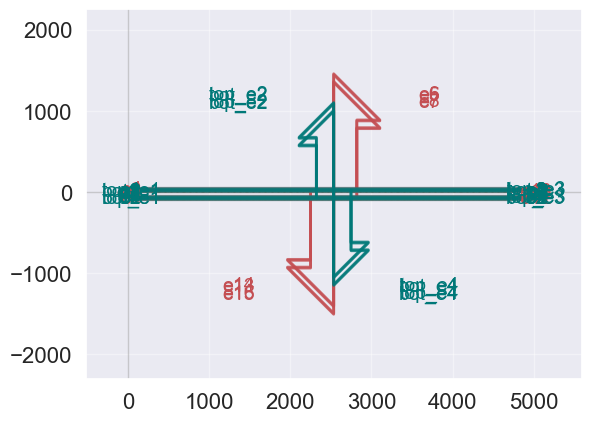

In [2]:
delta_length = 100

mzi_component = gf.components.mzi_phase_shifter(
    delta_length=delta_length,
    length_x=5000,
    straight_x_top=gf.components.straight_pn,
    straight_x_bot=gf.components.straight_pn,
)

mzi_netlist_for_test = mzi_component.get_netlist()

mzi_component

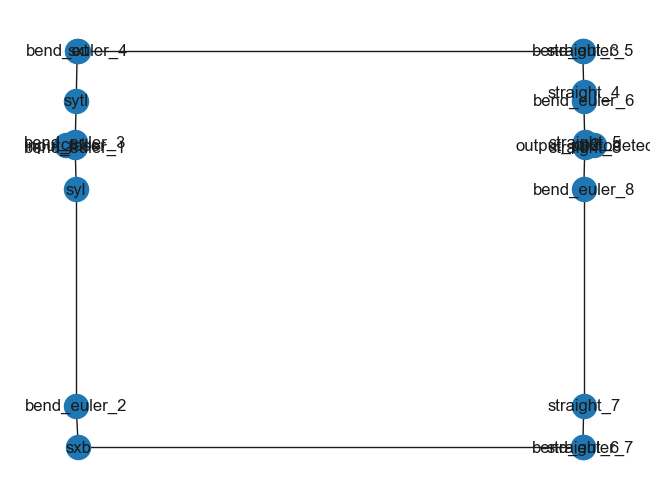

In [3]:
#We modify the models dict with the junction we want to simulate
mzi_circuit = PhotonicCircuit(mzi_netlist_for_test, original_models_dict)

input_port = mzi_circuit.ports[0]
output_port = mzi_circuit.ports[1]

mzi_circuit.add_laser_port(input_port, mzi_circuit.positions)
mzi_circuit.add_photodetector_port(output_port, mzi_circuit.positions)

pos = {k: (v["x"], v["y"]) for k, v in mzi_circuit.positions.items()}

nx.draw(
    mzi_circuit.graph,
    with_labels=True,
    font_weight=8,
    pos=pos,
)

In [4]:
mzi_circuit.update_all_edges()

Text(0.5, 1.0, 'Heater Voltage Sweep')

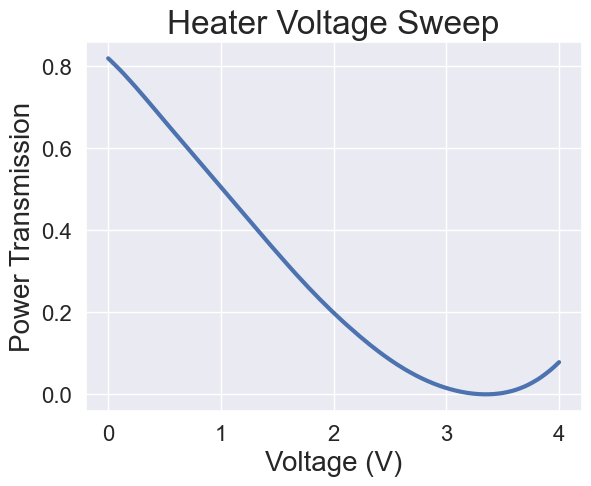

In [5]:
pn_comp_refs = mzi_circuit.return_components_callback(["sxt","sxb"])
top_pn = pn_comp_refs[0]
bottom_pn = pn_comp_refs[1]
voltage_sweep = np.linspace(0,4,num=1000)
storage = []
for v in voltage_sweep:
    top_pn.update_voltage(v)
    bottom_pn.update_voltage(4-v)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage.append(detector_value[0])

top_pn.update_voltage(0)
bottom_pn.update_voltage(0)

plt.figure()
plt.plot(voltage_sweep,storage)
plt.xlabel("Voltage (V)")
plt.ylabel("Power Transmission")
plt.title("Heater Voltage Sweep")

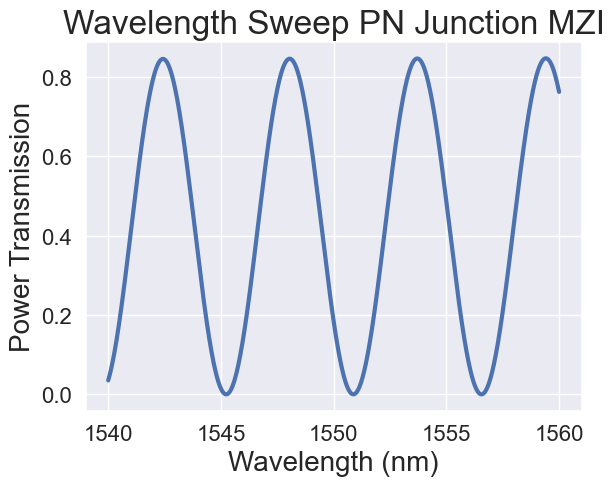

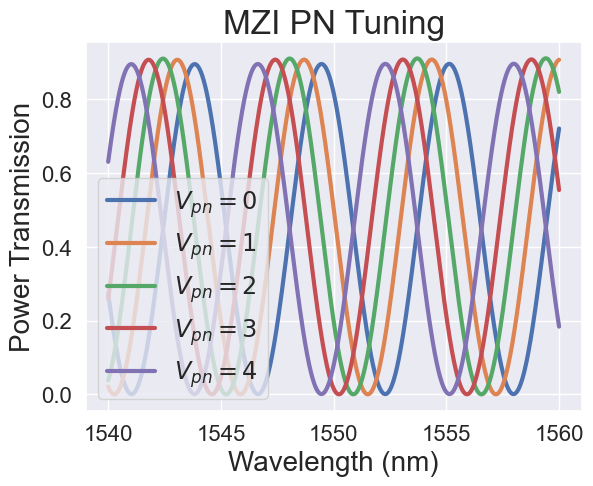

In [6]:
wavelength_sweep = np.linspace(1.54e-6,1.56e-6,num=2000)
storage = []
for wl in wavelength_sweep:
    mzi_circuit.update_wavelength(wl)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage.append(detector_value[0])

mzi_circuit.update_wavelength(1.55e-6)

plt.figure()
plt.plot(wavelength_sweep*1e9,storage)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Power Transmission")
plt.title("Wavelength Sweep PN Junction MZI")
plt.show()

wavelength_sweep = np.linspace(1.54e-6,1.56e-6,num=2000)
storage_V0 = []
storage_V1 = []
storage_V2 = []
storage_V3 = []
storage_V4 = []
for wl in wavelength_sweep:
    mzi_circuit.update_wavelength(wl)
    top_pn.update_voltage(0)
    bottom_pn.update_voltage(4-0)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage_V0.append(detector_value[0])

    top_pn.update_voltage(1)
    bottom_pn.update_voltage(4-1)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage_V1.append(detector_value[0])

    top_pn.update_voltage(2)
    bottom_pn.update_voltage(4-2)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage_V2.append(detector_value[0])

    top_pn.update_voltage(3)
    bottom_pn.update_voltage(4-3)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage_V3.append(detector_value[0])

    top_pn.update_voltage(4)
    bottom_pn.update_voltage(4-4)
    mzi_circuit.update_all_edges()
    detector_value = mzi_circuit.readout_from_photodetectors()
    storage_V4.append(detector_value[0])

mzi_circuit.update_wavelength(1.55e-6)

plt.figure()
plt.plot(wavelength_sweep*1e9,storage_V0)
plt.plot(wavelength_sweep*1e9,storage_V1)
plt.plot(wavelength_sweep*1e9,storage_V2)
plt.plot(wavelength_sweep*1e9,storage_V3)
plt.plot(wavelength_sweep*1e9,storage_V4)
plt.legend([
    r"$V_{pn}=0$",
    r"$V_{pn}=1$",
    r"$V_{pn}=2$",
    r"$V_{pn}=3$",
    r"$V_{pn}=4$",
    ],
    loc='lower left')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Power Transmission")
plt.title("MZI PN Tuning")
plt.show()


## Now we are going to create a sweep of the performance of different MZIs with different junctions and dopings

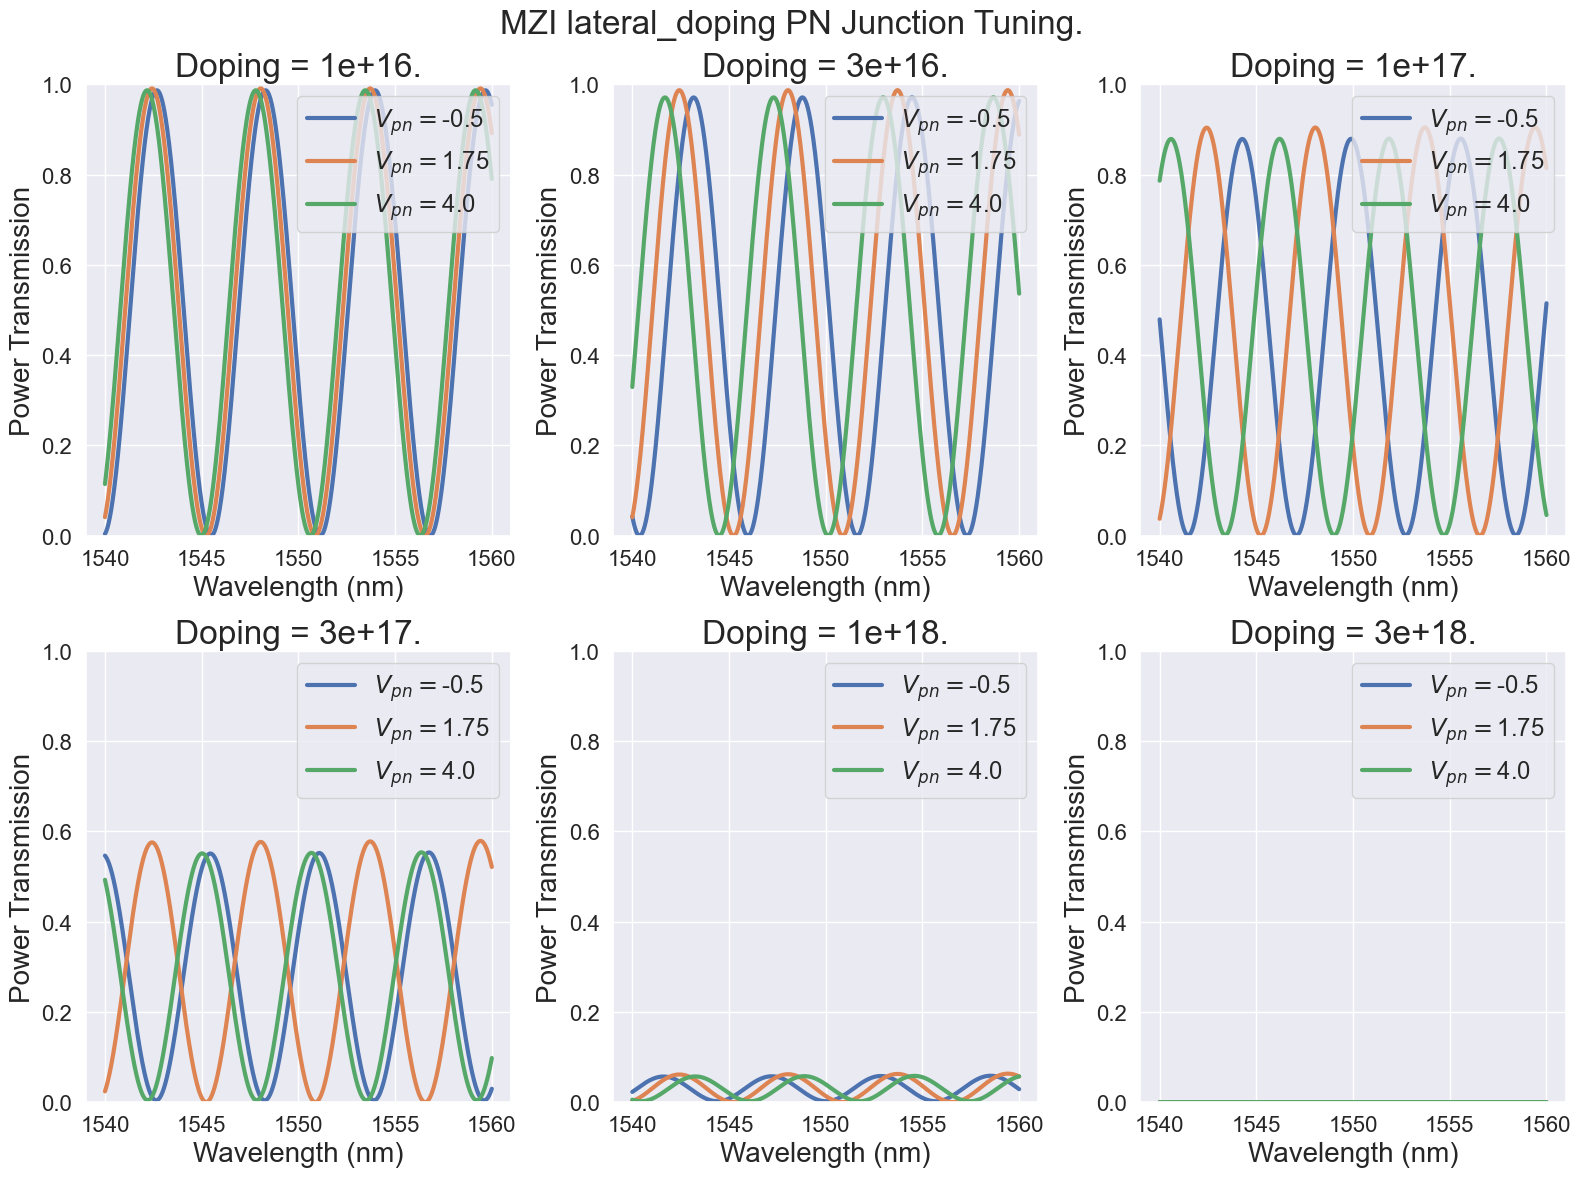

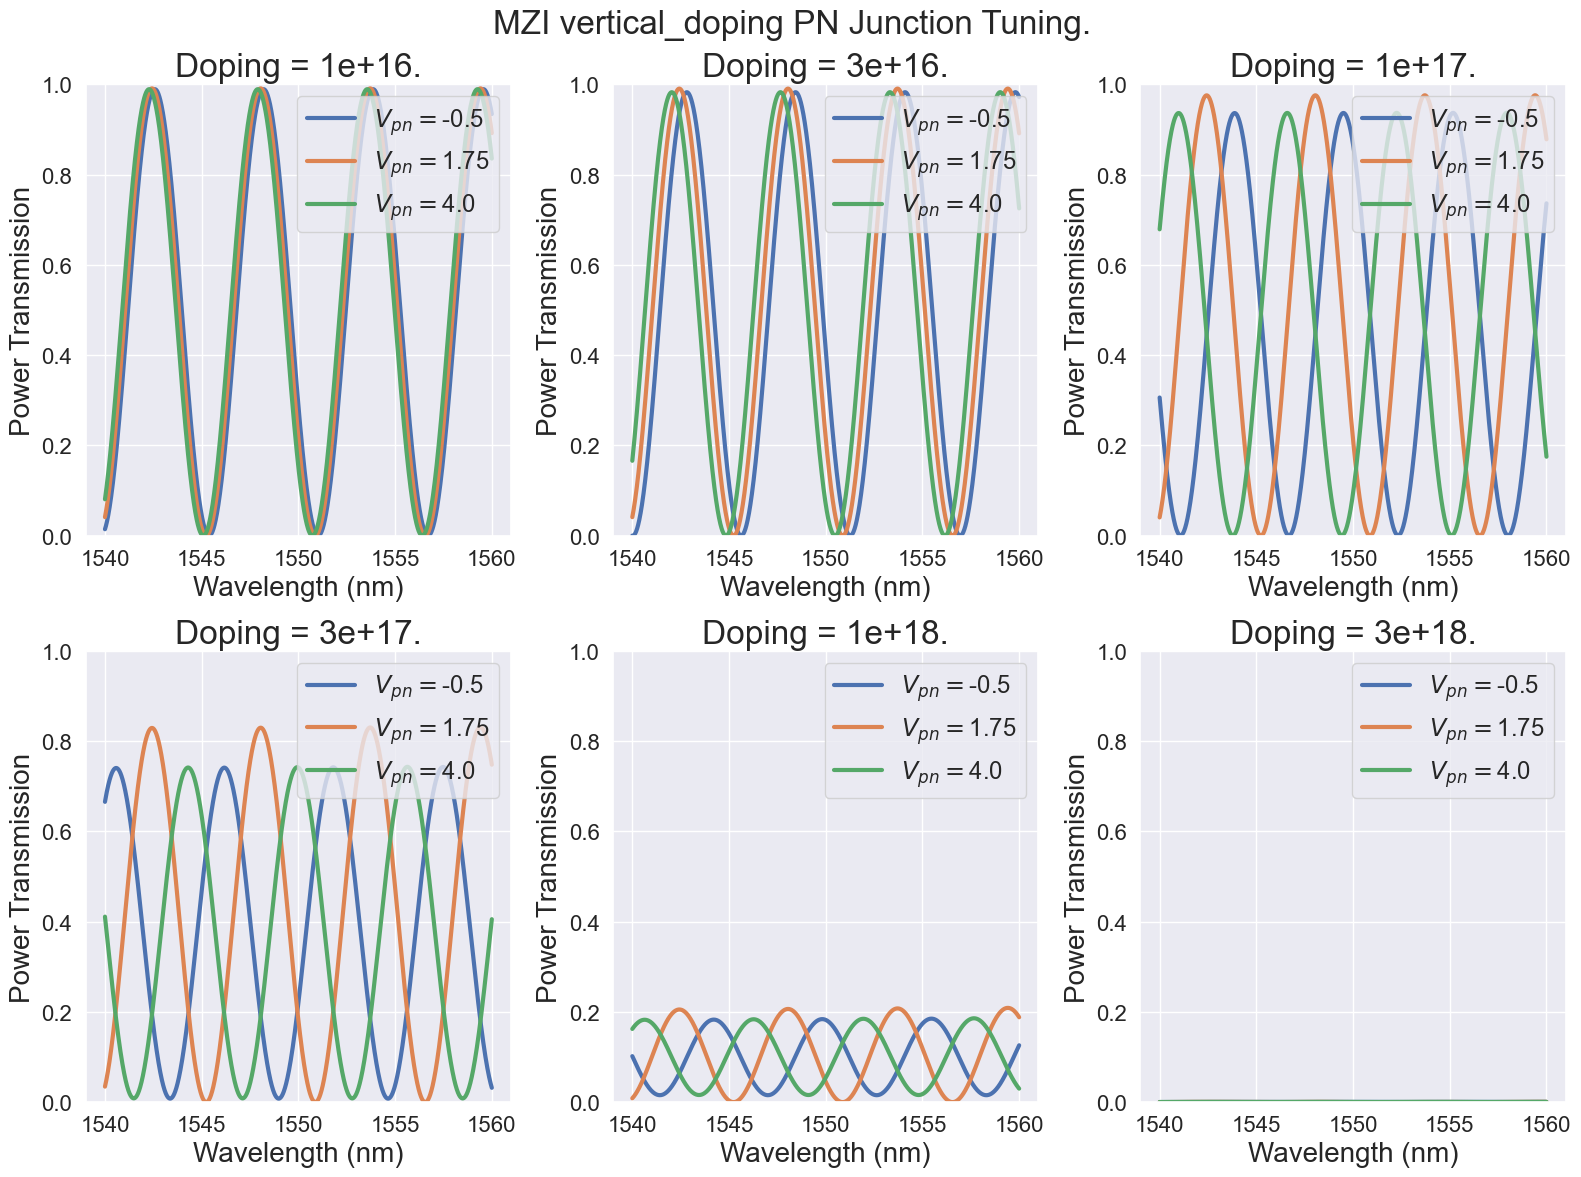

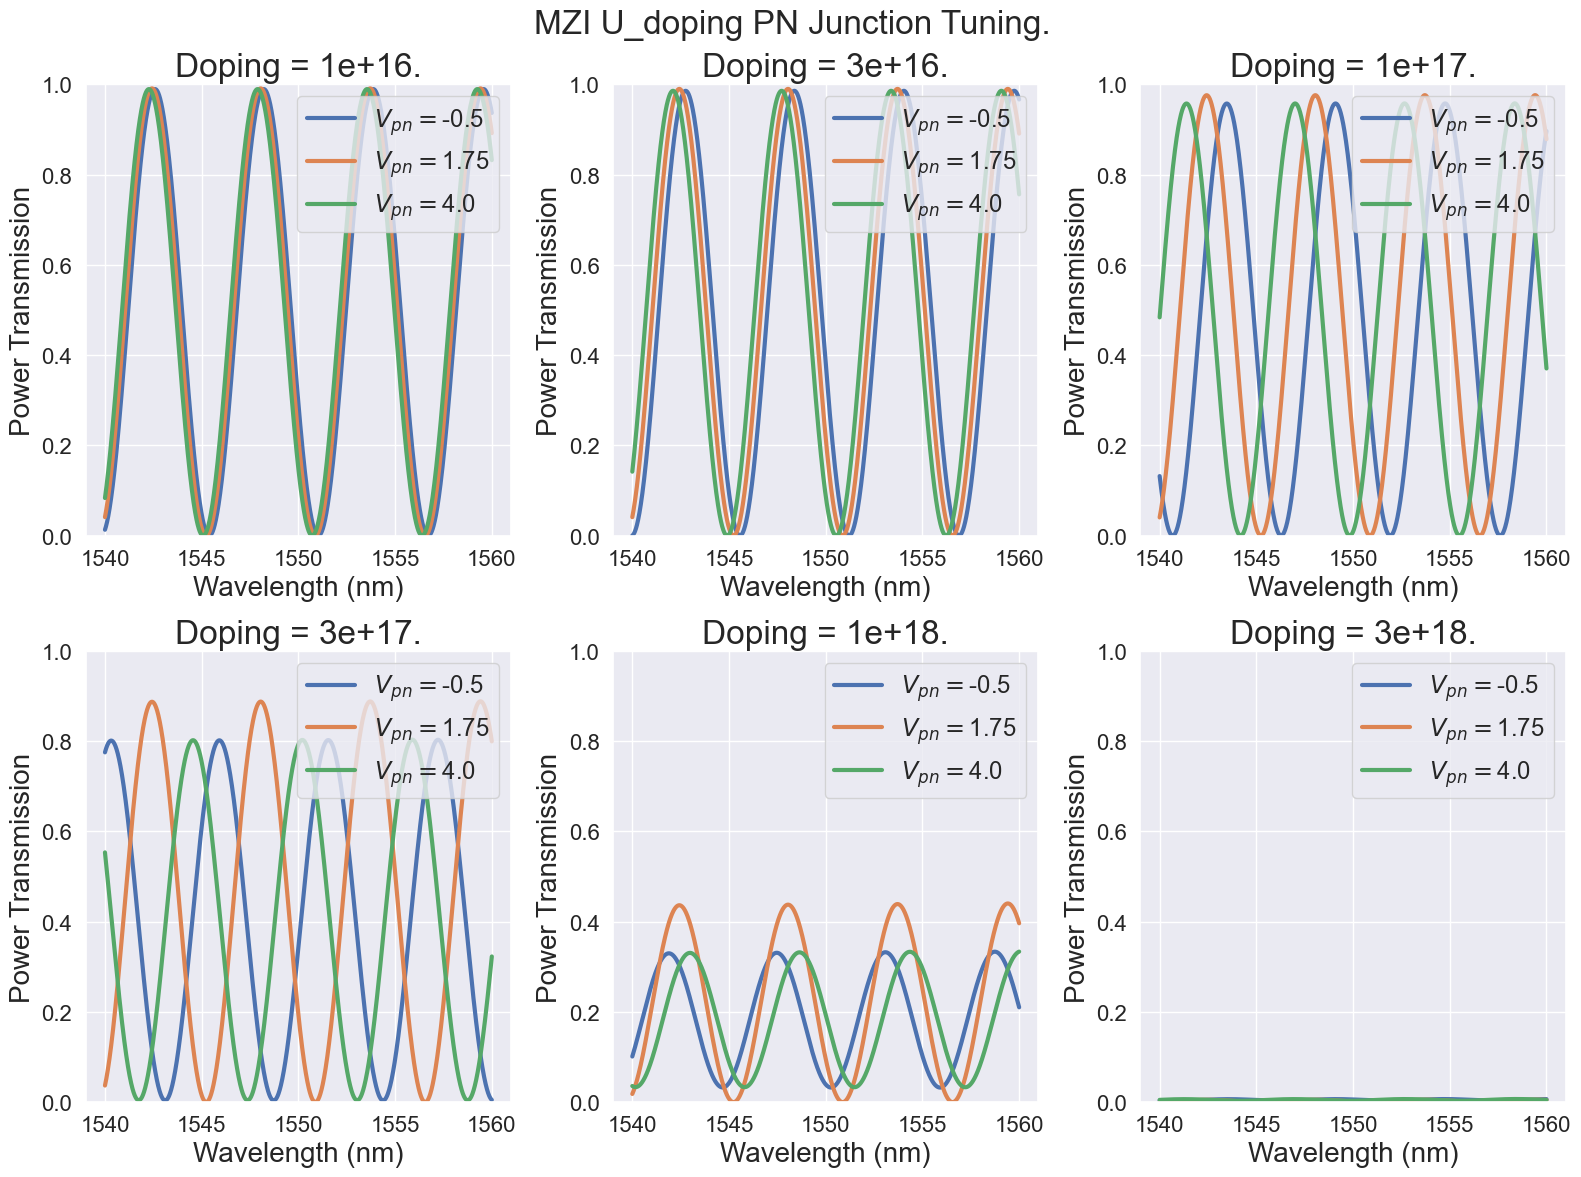

In [7]:
def doping_junction_sweep(doping,junction):
    # Doping must be in [1E16,3E16,1E17,3E17,1E18,3E18]
    # Junction must be in ['lateral_doping','vertical_doping','U_doping','MOSCAP_doping']

    junction_to_voltage_sweep_mapping  = {
        "lateral_doping": np.linspace(-0.5,4,num=1000),
        "vertical_doping": np.linspace(-0.5,4,num=1000),
        "U_doping": np.linspace(-0.5,4,num=1000),
        "MOSCAP_doping": np.linspace(-3,0,num=1000)
    }
    voltage_sweep = junction_to_voltage_sweep_mapping[junction]
    original_models_dict['straight_pin'] = functools.partial(straight_pn, junction=junction, doping=doping)
    mzi_circuit = PhotonicCircuit(mzi_netlist_for_test, original_models_dict)

    input_port = mzi_circuit.ports[0]
    output_port = mzi_circuit.ports[1]

    mzi_circuit.add_laser_port(input_port, mzi_circuit.positions)
    mzi_circuit.add_photodetector_port(output_port, mzi_circuit.positions)

    pn_comp_refs = mzi_circuit.return_components_callback(["sxt","sxb"])
    top_pn = pn_comp_refs[0]
    bottom_pn = pn_comp_refs[1]

    wavelength_sweep = np.linspace(1.54e-6,1.56e-6,num=2000)
    mzi_circuit.update_wavelength(1.55e-6)

    wavelength_sweep = np.linspace(1.54e-6,1.56e-6,num=2000)
    storage_min = []
    storage_mean = []
    storage_max = []
    for wl in wavelength_sweep:
        mzi_circuit.update_wavelength(wl)
        top_pn.update_voltage(np.min(voltage_sweep))
        bottom_pn.update_voltage(np.max(voltage_sweep))
        mzi_circuit.update_all_edges()
        detector_value = mzi_circuit.readout_from_photodetectors()
        storage_min.append(detector_value[0])

        top_pn.update_voltage(np.mean(voltage_sweep))
        bottom_pn.update_voltage(np.mean(voltage_sweep))
        mzi_circuit.update_all_edges()
        detector_value = mzi_circuit.readout_from_photodetectors()
        storage_mean.append(detector_value[0])

        top_pn.update_voltage(np.max(voltage_sweep))
        bottom_pn.update_voltage(np.min(voltage_sweep))
        mzi_circuit.update_all_edges()
        detector_value = mzi_circuit.readout_from_photodetectors()
        storage_max.append(detector_value[0])

    mzi_circuit.update_wavelength(1.55e-6)

    return wavelength_sweep, voltage_sweep, storage_min, storage_mean, storage_max

doping_sweep = [1E16,3E16,1E17,3E17,1E18,3E18]
junction_sweep = ['lateral_doping','vertical_doping','U_doping'] # MOSCAP doping not included as it is really for use as an intensity modulator
for j in junction_sweep:
    fig, axs = plt.subplots(2, 3,figsize=(16,12))
    axs = axs.flatten()
    plt.suptitle(f"MZI {j} PN Junction Tuning.")

    for dindex, d in enumerate(doping_sweep):
        wavelength_sweep, voltage_sweep, storage_min, storage_mean, storage_max = doping_junction_sweep(d,j)
        axs[dindex].plot(wavelength_sweep*1e9,storage_min)
        axs[dindex].plot(wavelength_sweep*1e9,storage_mean)
        axs[dindex].plot(wavelength_sweep*1e9,storage_max)
        axs[dindex].set_xlabel("Wavelength (nm)")
        axs[dindex].set_ylabel("Power Transmission")
        axs[dindex].set_title(f"Doping = {d}.")
        axs[dindex].set_ylim(0,1)
        axs[dindex].legend([
            r"$V_{pn}=$" + f"{np.min(voltage_sweep)}",
            r"$V_{pn}=$" + f"{np.mean(voltage_sweep)}",
            r"$V_{pn}=$" + f"{np.max(voltage_sweep)}",
            ],
            loc='upper right')
    plt.tight_layout()
    plt.show()